In [ ]:
# if needed run this
#from dustmaps.config import config
#config.reset()

In [58]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp

from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [137]:
import importlib


# Clear the module from cache
if "local_GRBafterglows_metric" in sys.modules:
    del sys.modules["local_GRBafterglows_metric"]

# Re-import and reload the updated module
import local_GRBafterglows_metric
importlib.reload(local_GRBafterglows_metric)

# Import updated classes and functions from the refactored module
from local_GRBafterglows_metric import (
    GRBAfterglowLC,
    GRBAfterglowDetectMetric,
    GRBAfterglowBetterDetectMetric,
    generateGRBPopSlicer,
    GRBAfterglowSpecTriggerableMetric,
    GRBAfterglowCharacterizeMetric,
    GRBAfterglowColorEvolveMetric,
    GRBAfterglowHistoricalMatchMetric,
    generateGRBAfterglowTemplates
)



# Confirm path
print(local_GRBafterglows_metric.__file__)

# Filter utility: select events within t_start and t_end range
def filter_population_by_time(slicer, t_start, t_end):
    peak_times = slicer.slice_points['peak_time']
    mask = (peak_times >= t_start) & (peak_times < t_end)

    ra_new = slicer.slice_points['ra'][mask]
    dec_new = slicer.slice_points['dec'][mask]

    new_slicer = UserPointsSlicer(ra=ra_new, dec=dec_new, badval=0)

    # Copy all fields
    new_slicer.slice_points = {k: v[mask] for k, v in slicer.slice_points.items()}

    # Overwrite sid to ensure alignment with metric index
    new_slicer.slice_points['sid'] = np.arange(len(new_slicer.slice_points['ra']))

    return new_slicer

/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/GRBafterglows/local_GRBafterglows_metric.py


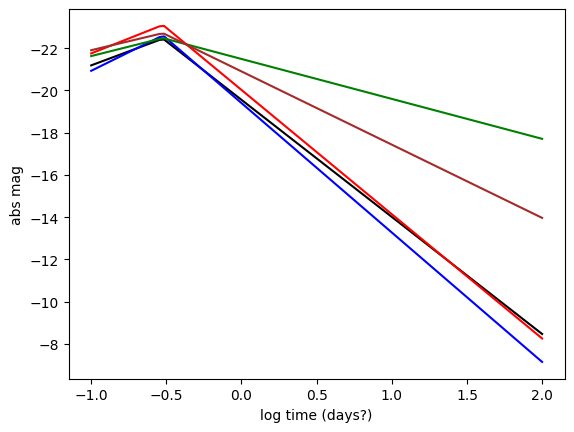

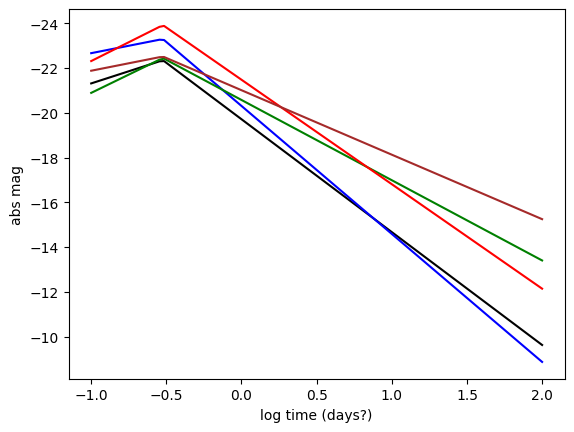

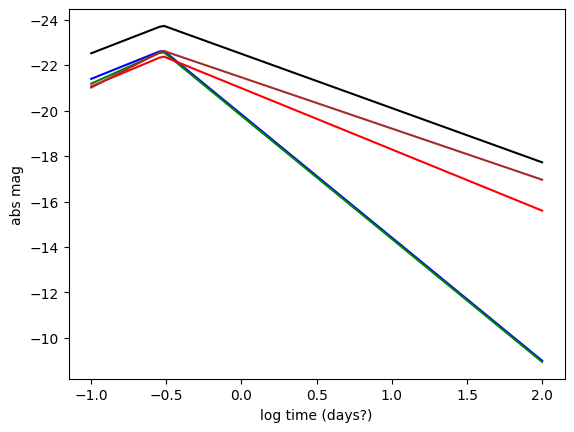

In [6]:
lcdict = pickle.load(open("GRBAfterglow_templates.pkl", "rb"))
for i in range(3):
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                     lcdict["lightcurves"][i]['u']['mag'], color='k')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                      lcdict["lightcurves"][i]['g']['mag'], color='b')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                      lcdict["lightcurves"][i]['r']['mag'], color='g')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                      lcdict["lightcurves"][i]['i']['mag'], color='r')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                    lcdict["lightcurves"][i]['z']['mag'], color='brown')
    ylims = plt.ylim()
    plt.xlabel("log time (days?)")
    plt.ylabel("abs mag")
    plt.ylim(*ylims[::-1])
    plt.show()

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Simulated 4193 GRB events using rate_density = 1.0e-08


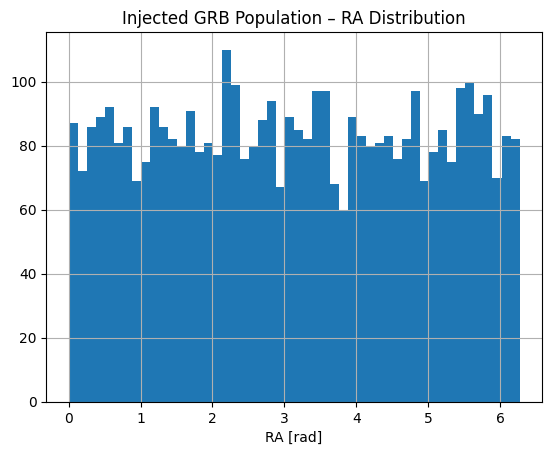

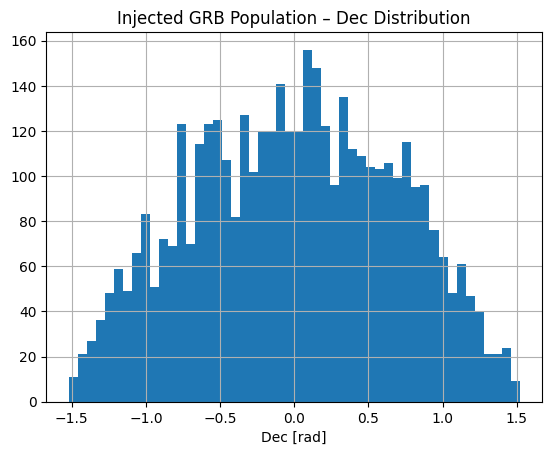

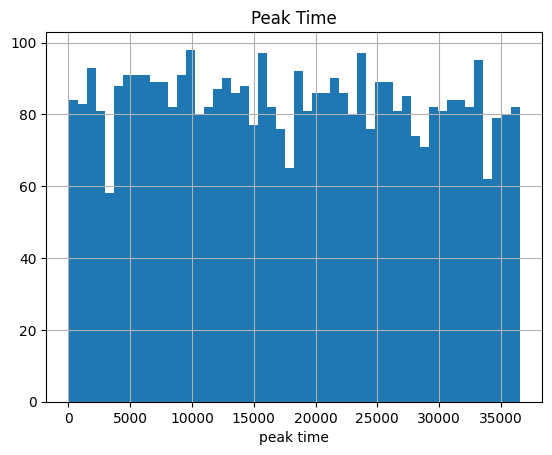

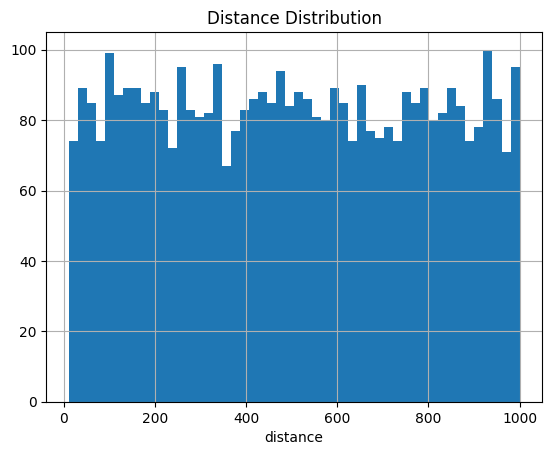

[DEBUG]Print 5 sample before SkyCoord - ra,dec: {'sid': array([   0,    1,    2, ..., 4190, 4191, 4192], shape=(4193,)), 'ra': array([2.0888249 , 0.61359232, 1.11673801, ..., 5.70640853, 1.80396141,
       5.11735991], shape=(4193,)), 'dec': array([ 0.96181493, -0.58486081, -0.3178237 , ...,  0.14635526,
        0.3178237 , -0.49970504], shape=(4193,)), 'gall': array([2.84222164, 4.13190023, 3.72483784, ..., 1.13297323, 3.43519712,
       0.18510574], shape=(4193,)), 'galb': array([ 0.54842112, -1.21773934, -0.73839078, ..., -0.57777915,
        0.15043777, -0.36693003], shape=(4193,))}
[DEBUG] coords.dec[:5]: [ 55.10793643 -33.51005607 -18.20995686   7.18075578   7.78271439] deg
[DEBUG] coords.dec.unit: deg


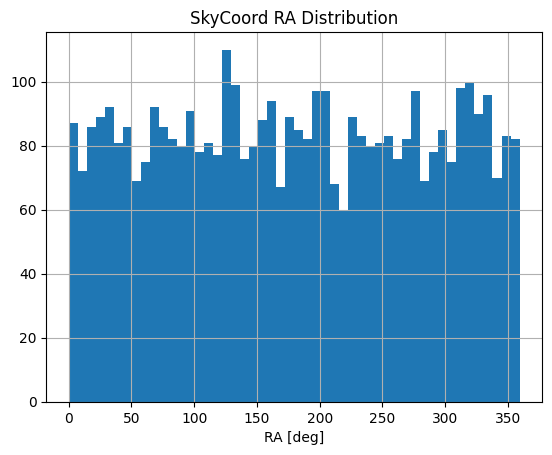

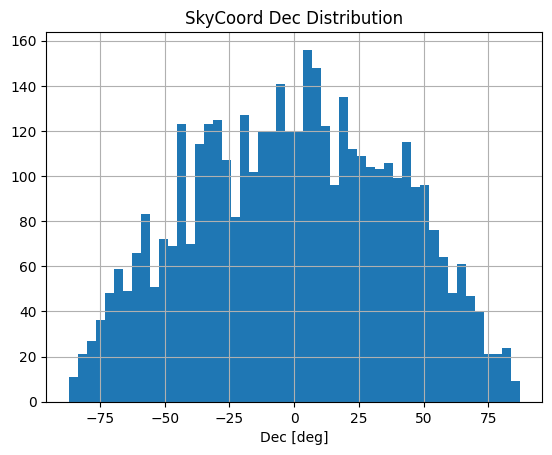

Saved GRB population to GRBafterglows_fixedpop_detectonly/rd1em08/GRB_population_fixedpop_10yr_rd1em08.pkl


In [138]:
#all configs
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
rate_density = 1e-8
rate_str = f"rd{rate_density:.0e}".replace("-", "m")  # Example: 1e-8 to rd1e-8
filters = ['u', 'g', 'r', 'i', 'z', 'y']
grbs_dir = f"GRBafterglows_fixedpop_detectonly/{rate_str}"
grb_templates_file = "GRBAfterglow_templates.pkl"
grb_pop_file = os.path.join(grbs_dir, f"GRB_population_fixedpop_10yr_{rate_str}.pkl")
dmin, dmax = 10, 1000
gal_lat_cut = None
os.makedirs(grbs_dir, exist_ok=True)
db_dir = "../"


t_start = 1
t_end = 36520

# ---- Template Setup ----
if not os.path.exists(grb_templates_file):
    from local_GRBafterglows_metric import generateGRBAfterglowTemplates
    generateGRBAfterglowTemplates(save_to=grb_templates_file)
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

# ---- Population Setup ----
if not os.path.exists(grb_pop_file):
    slicer = generateGRBPopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut, rate_density=rate_density,
        save_to=grb_pop_file
    )
else:
    slicer = generateGRBPopSlicer(load_from=grb_pop_file)

n_events = len(slicer.slice_points['distance'])

## All 10 years


--- Running four_roll_v4.3.1_10yrs ---
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 754
mag_obs         | type: <class 'numpy.ndarray'> | length: 754
snr_obs         | type: <class 'numpy.ndarray'> | length: 754
filter          | type: <class 'numpy.ndarray'> | length: 754
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
rise_time_days  | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 973
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float6

/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_87009/3586306807.py:76: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


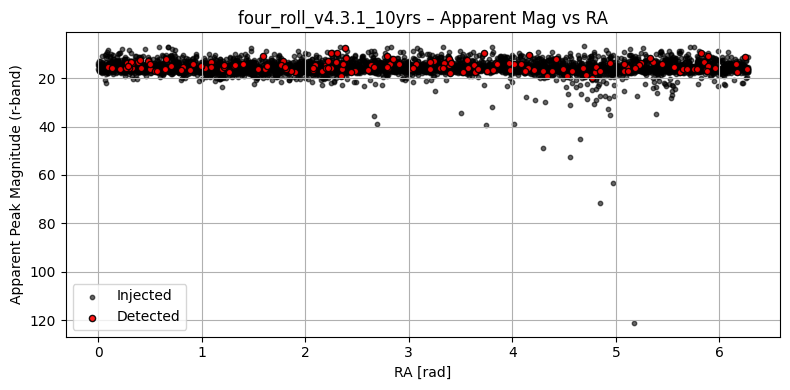

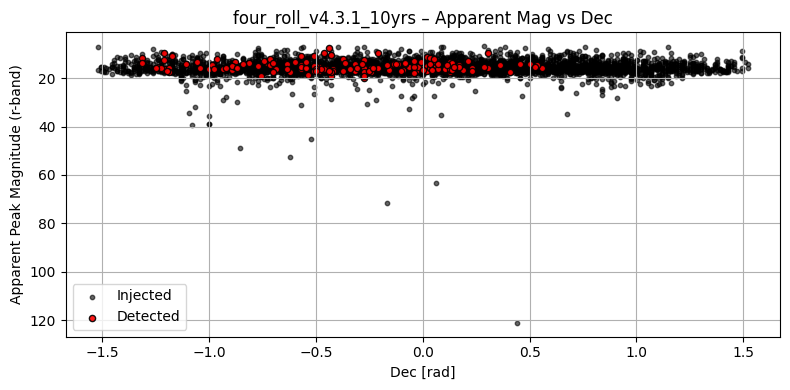

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
[DEBUG] Detected RA, Dec: 125.86, -31.39


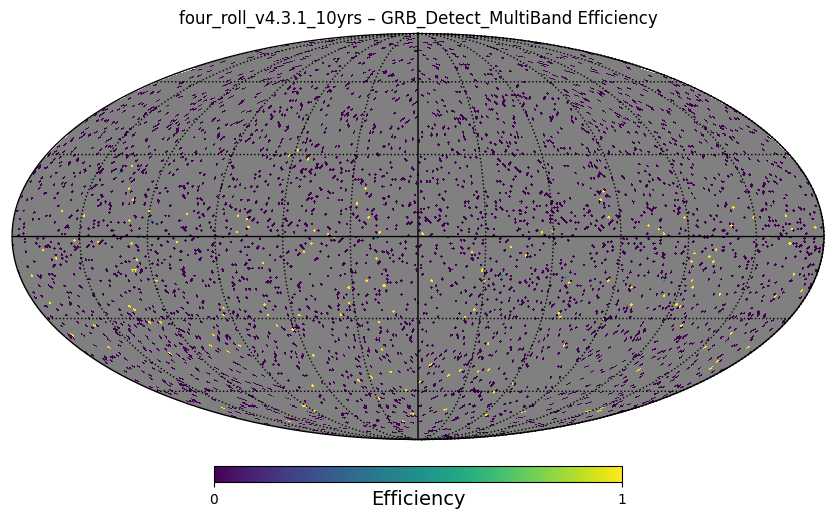

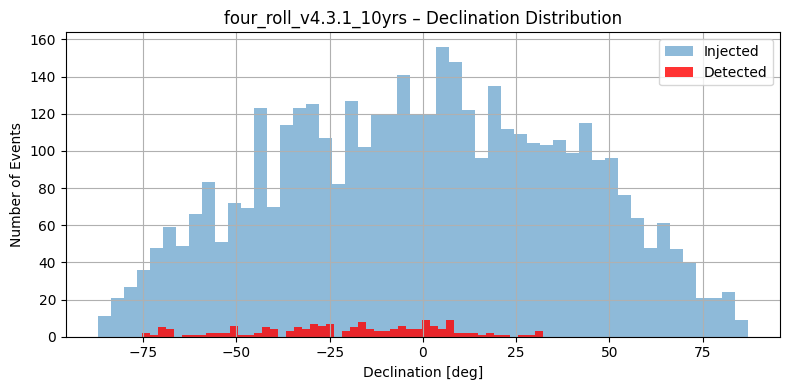

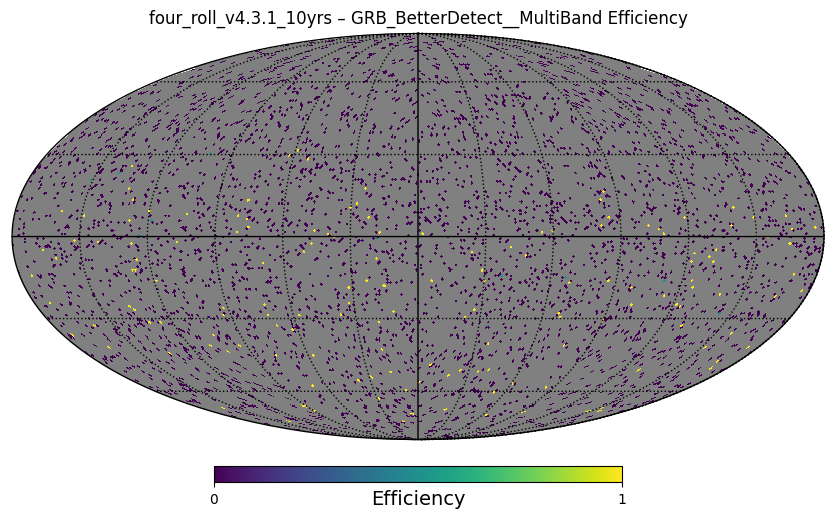

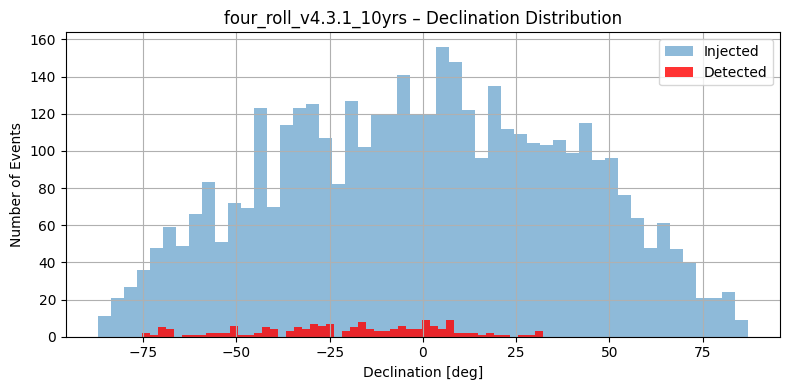

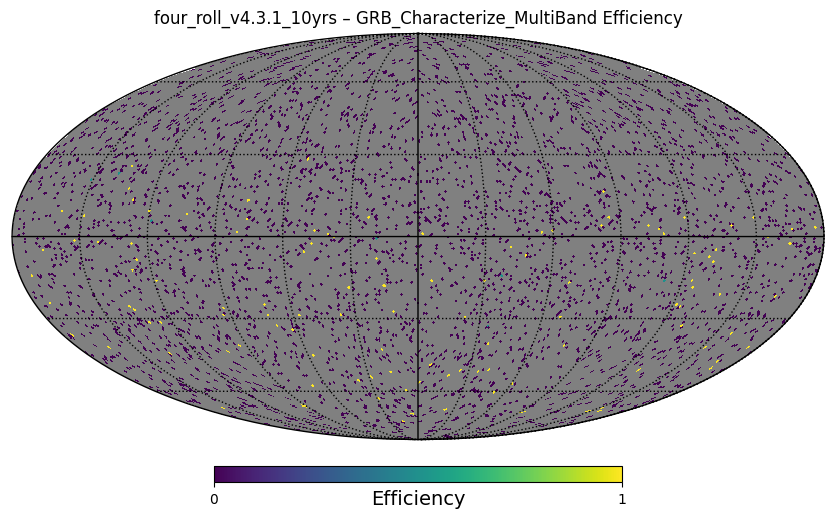

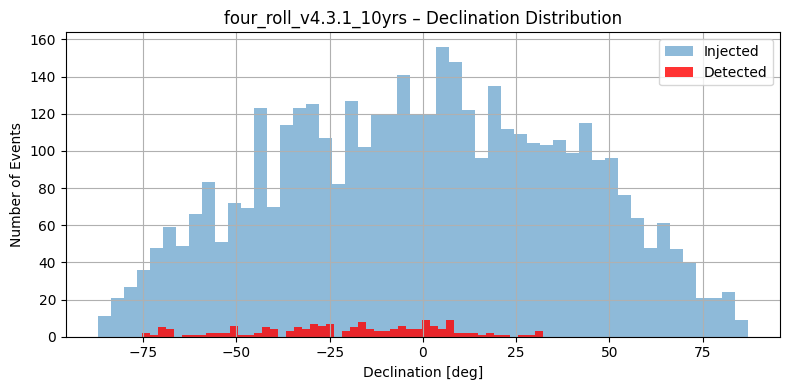

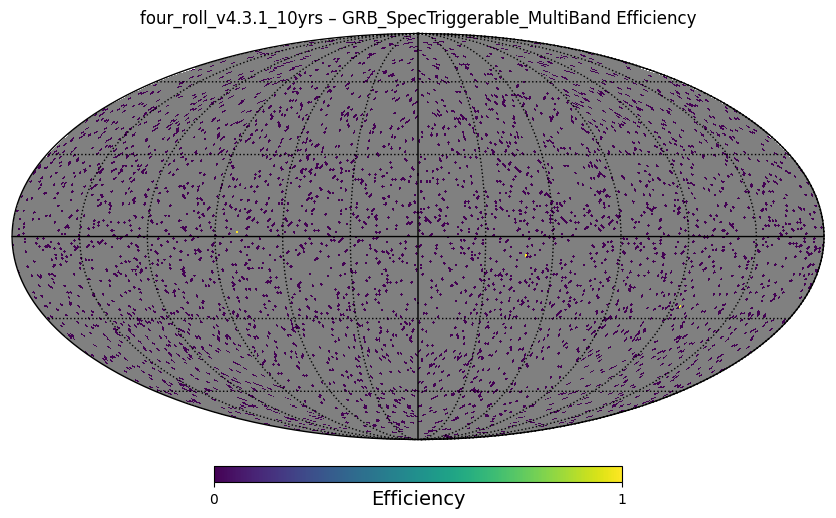

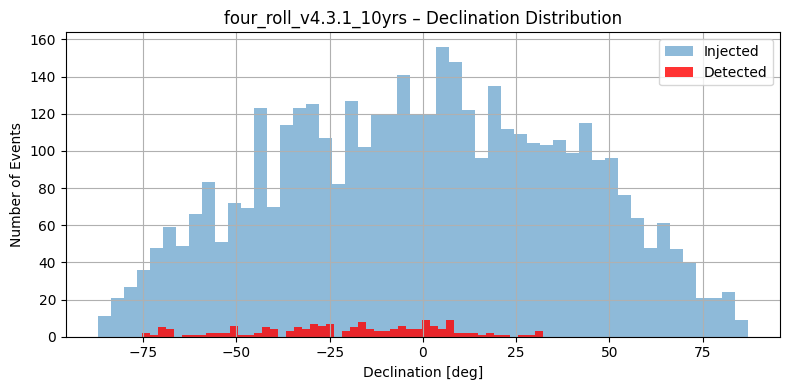

[DEBUG] Detected RA, Dec: 300.23, 2.39


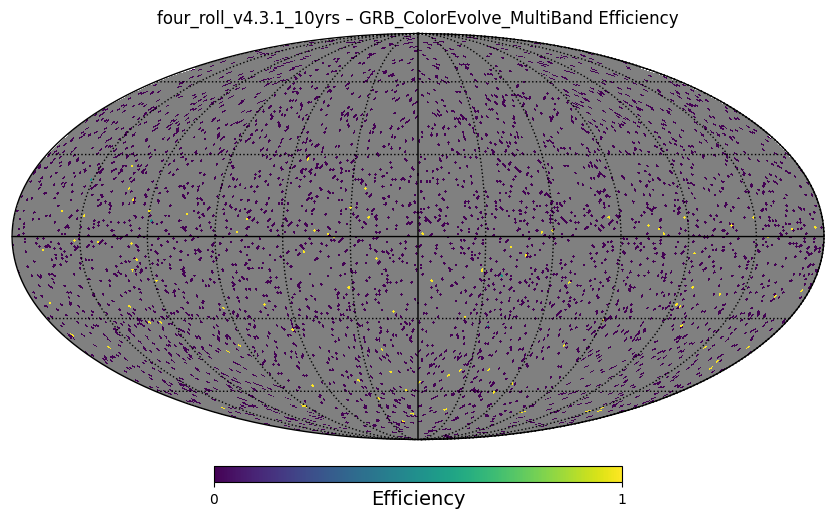

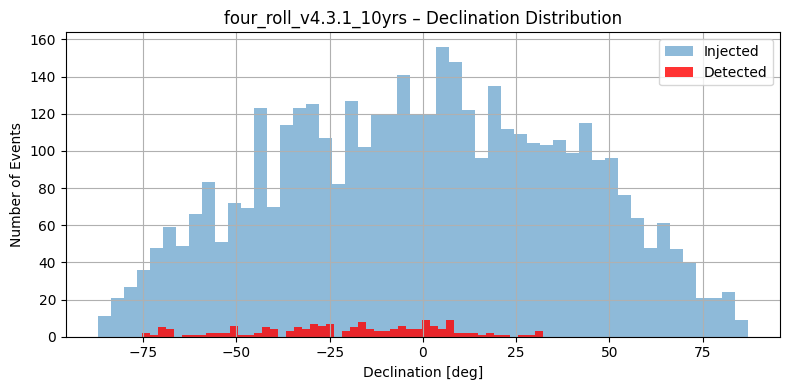

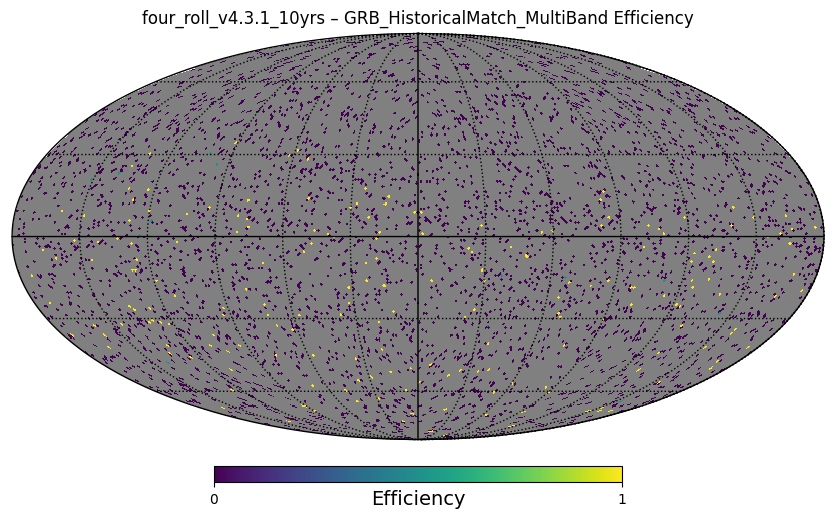

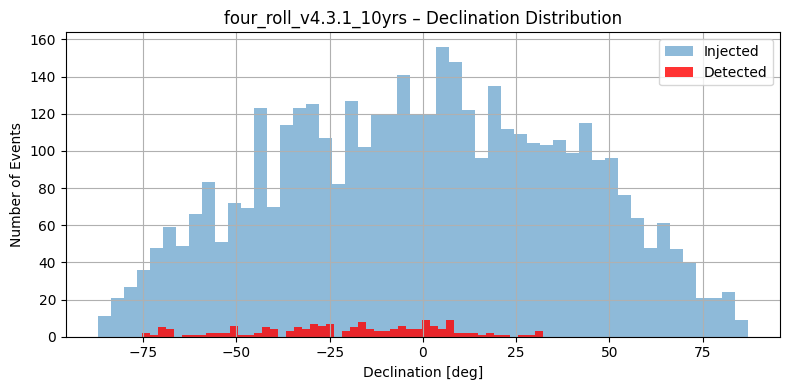

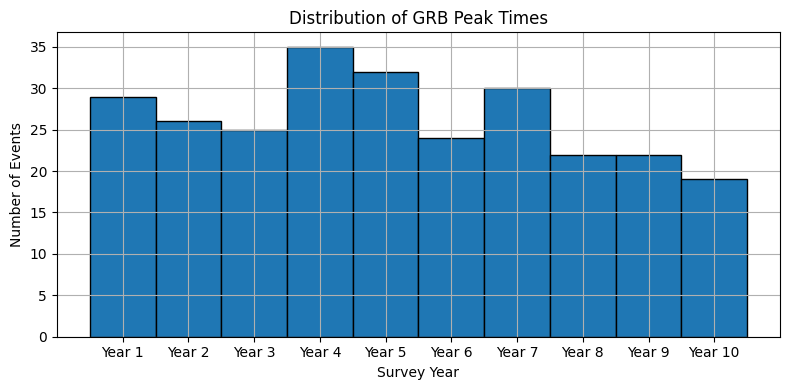


--- Running baseline_v4.3.1_10yrs ---
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 778
mag_obs         | type: <class 'numpy.ndarray'> | length: 778
snr_obs         | type: <class 'numpy.ndarray'> | length: 778
filter          | type: <class 'numpy.ndarray'> | length: 778
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
rise_time_days  | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 973
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64

/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_87009/3586306807.py:76: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


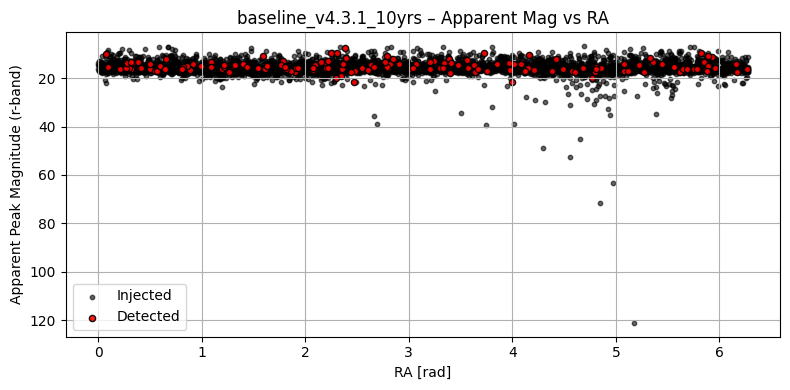

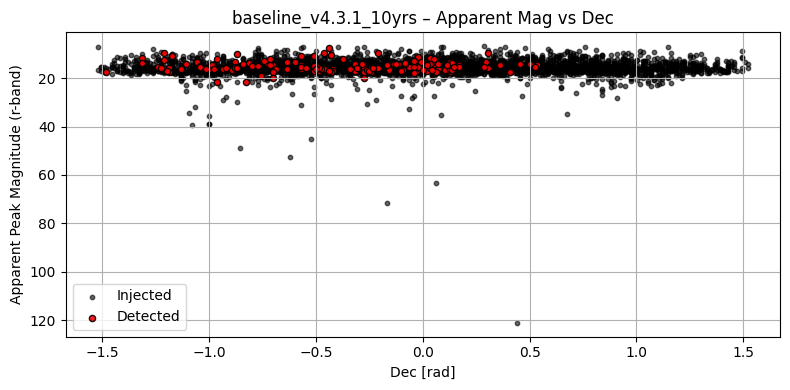

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


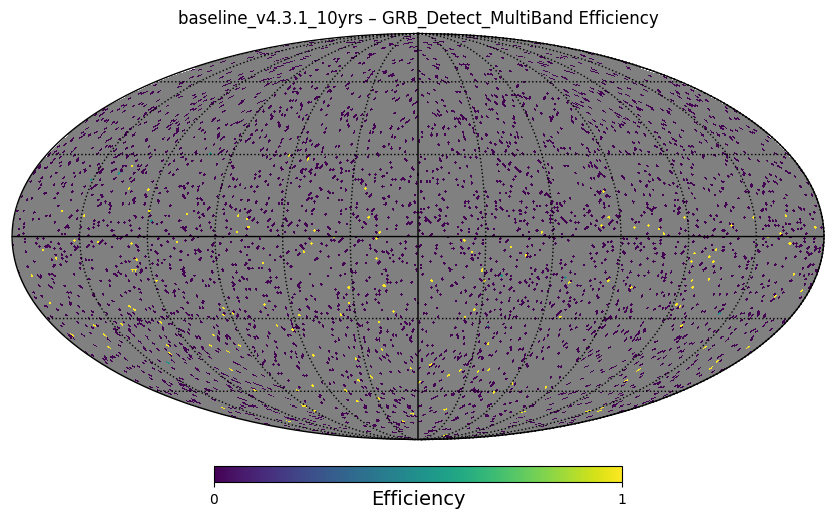

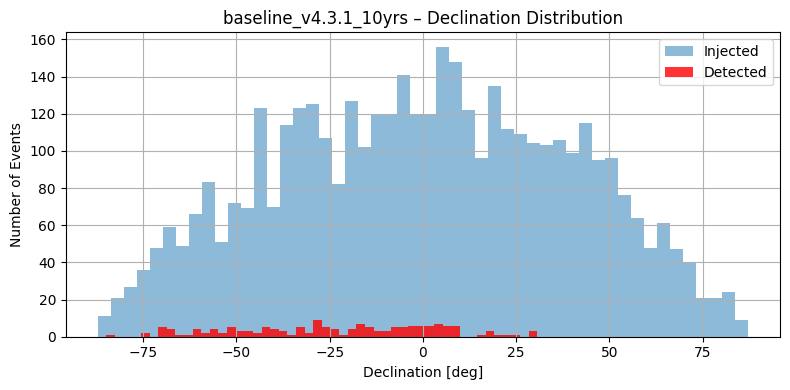

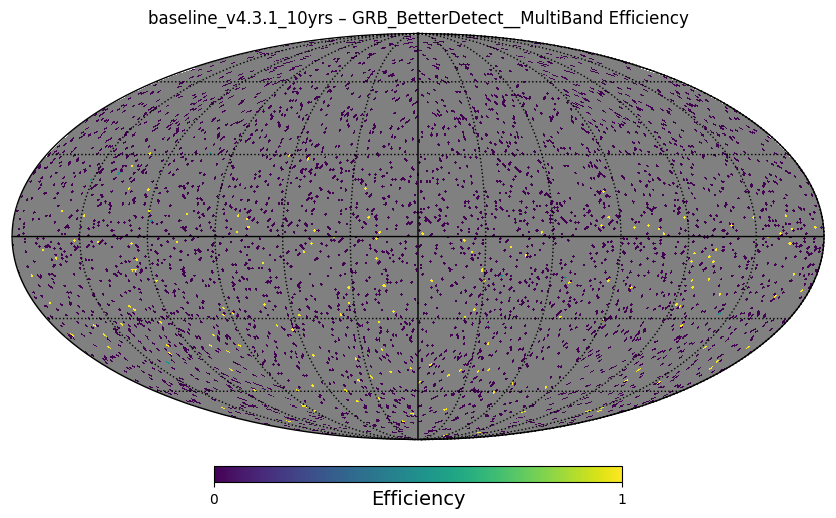

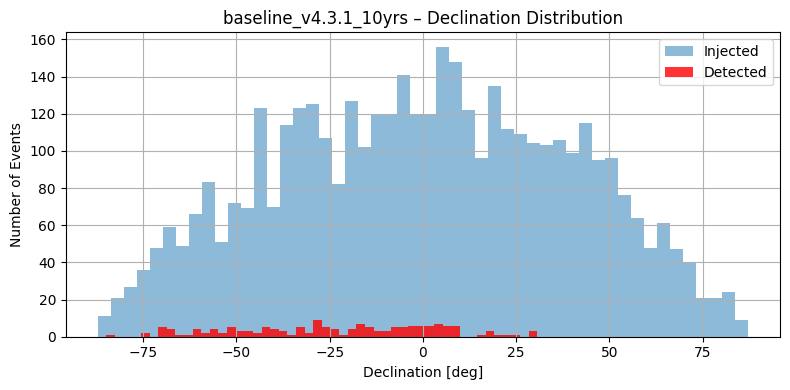

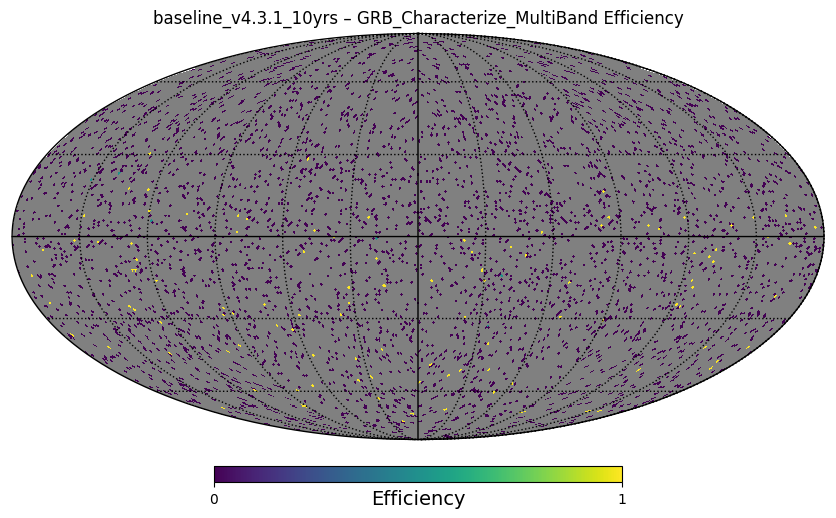

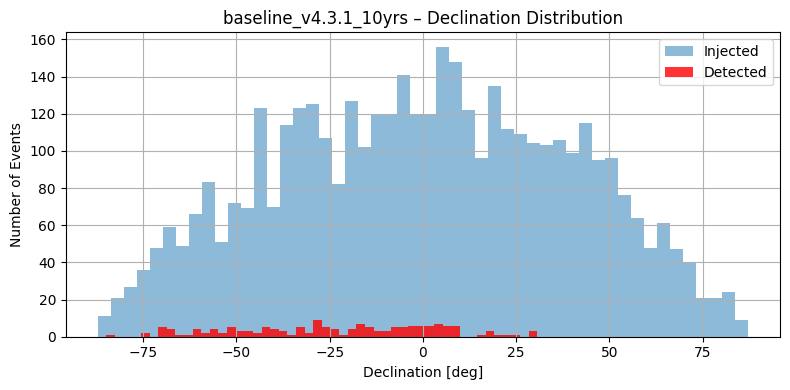

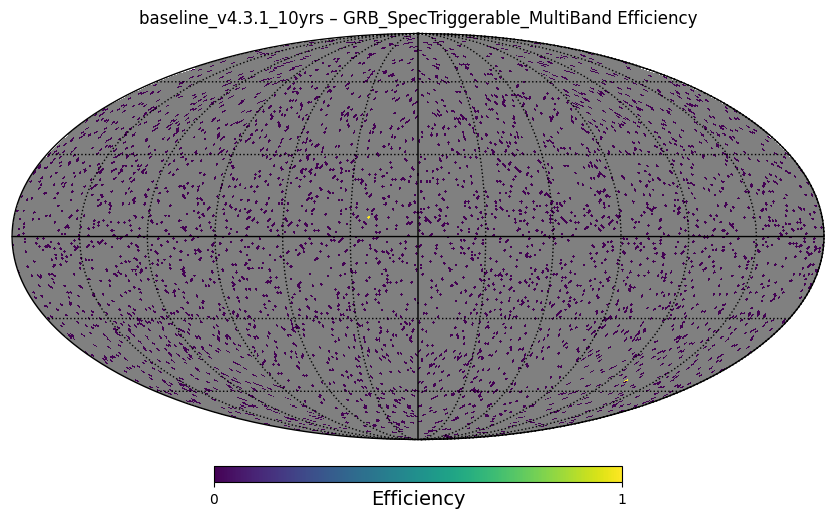

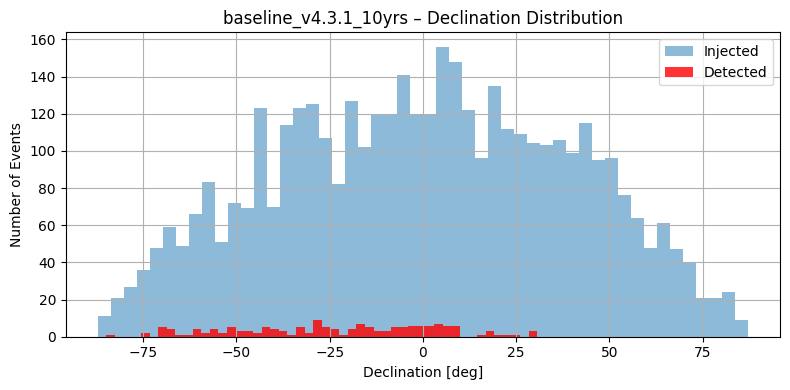

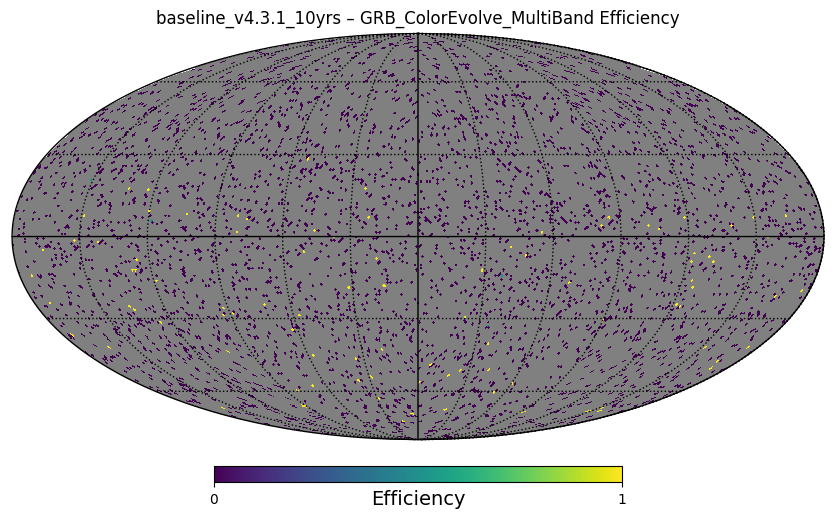

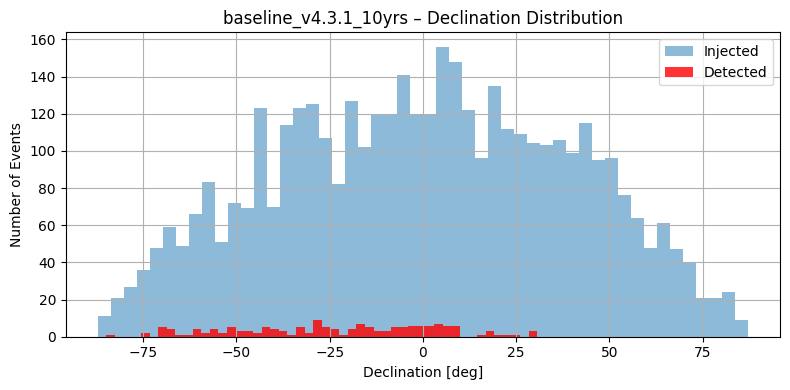

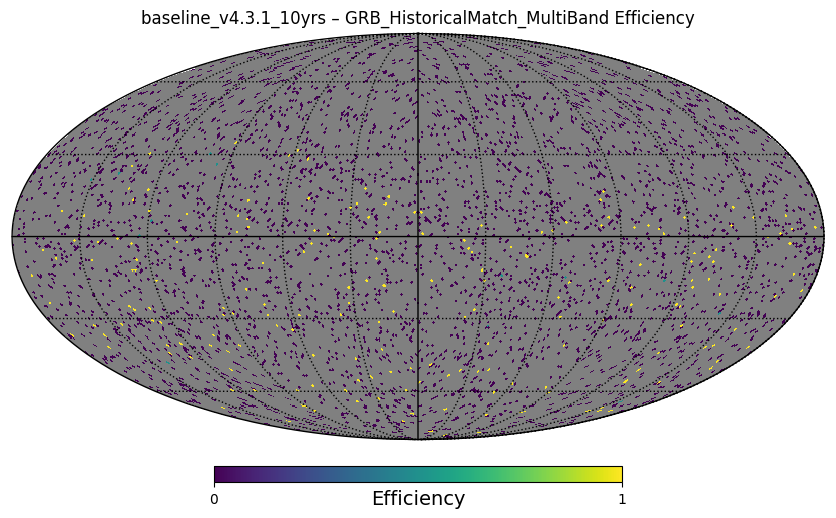

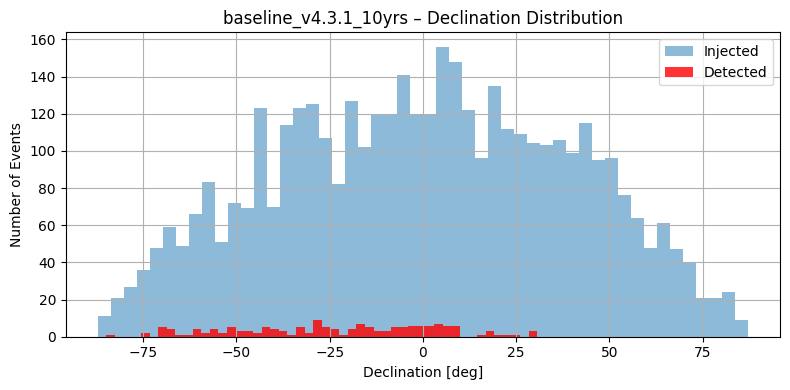

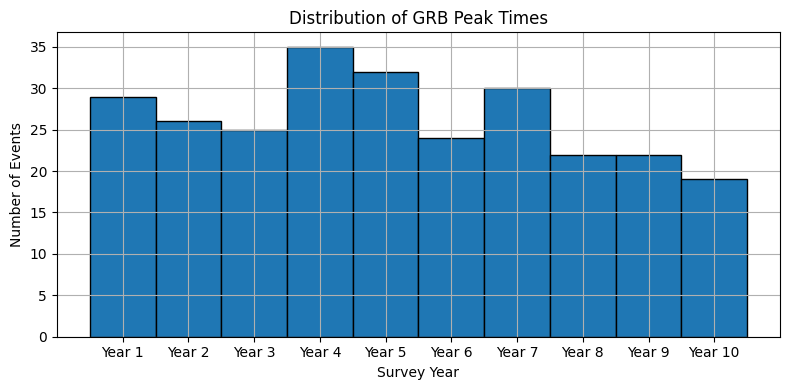

In [140]:
# ---- ALL 10 years Configuration ----
first = 1
for cadence in cadences:
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)

    print(f"\n--- Running {cadence} ---")

    #### per filter metric here
    per_filter_metrics = OrderedDict()
    filters = ['all']
    for filt in filters:
        detect = GRBAfterglowDetectMetric(metricName=f"GRB_Detect_{filt}", #filter_include=[filt], 
                                         lc_model=shared_lc_model)
                    #GRBAfterglowSpecTriggerableMetric(metricName=f"GRB_Detect_{filt}", filter_include=[filt], 
                    #                      lc_model=shared_lc_model)
        per_filter_metrics[f"GRB_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')

    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

        # save obs_data
    bundle = per_filter_metrics["GRB_Detect_all"]
    
    # Pull the actual metric instance used inside the bundle
    detect_metric = bundle.metric

    #get results
    obs_records = list(detect_metric.obs_records.values())

    #Error checking 1
    print("\nInspecting one obs_record before saving to CSV:")
    sample_record = obs_records[0]
    for key, val in sample_record.items():
        print(f"{key:15} | type: {type(val)}", end='')
        try:
            print(f" | length: {len(val)}")
        except TypeError:
            print(f" | value: {val}")

    #Error checking 2
    print("\nChecking consistency across all obs_records...")
    keys = obs_records[0].keys()
    for key in keys:
        lengths = [len(v[key]) if hasattr(v[key], '__len__') and not isinstance(v[key], str) else 1 for v in obs_records]
        if len(set(lengths)) > 1:
            print(f" Inconsistent lengths in field '{key}': {set(lengths)}")
    
    
    # Now get the results
    df_obs = pd.DataFrame.from_dict(detect_metric.obs_records).T
    df_obs = df_obs.reset_index().rename(columns={"index": "sid"})

    df_obs = pd.DataFrame.from_dict(detect_metric.obs_records).T.reset_index().rename(columns={"index": "sid"})

    # =======================================================================
    # Add calendar year assuming MJD0 = 59853.5 (LSST start)
    # Convert peak MJD to years since LSST start (365.25 days/year)
    df_obs["year"] = (df_obs["peak_time"] / 365.25).astype(int) + 1
    df_detected_per_year = df_obs[df_obs['detected'] == True].groupby("year").size().reset_index(name="n_detected")
    # =======================================================================


    # Convert problematic ndarray columns to lists before saving
    for col in ['filter', 'mjd_obs', 'mag_obs', 'snr_obs']:
        df_obs[col] = df_obs[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
    
    # Now save
    df_obs.to_csv(f"GRBafterglows_output/ObsRecords_{cadence}.csv", index=False)


    
    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])
    
    detected_mask = n_filters_detected_per_event >= 1
    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])

    print(f"Out of {n_events} simulated GRB events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


    # Plot: Apparent magnitude vs RA and Dec for one filter (e.g. 'r')
    filtername = 'r'
    ax1 = DustValues().ax1
    
    ras, decs, peak_mags, detected_flags = [], [], [], []
    
    for i in range(n_events):
        ra = slicer.slice_points['ra'][i]
        dec = slicer.slice_points['dec'][i]  # this is in radians already
        d = slicer.slice_points['distance'][i]
        ebv = slicer.slice_points['ebv'][i]
        file_indx = slicer.slice_points['file_indx'][i]
        
        m_peak = np.min(shared_lc_model.data[file_indx][filtername]['mag'])
        A = ax1[filtername] * ebv
        dm = 5 * np.log10(d * 1e6) - 5
        m_app = m_peak + dm + A
    
        ras.append(ra)
        decs.append(dec)
        peak_mags.append(m_app)
    
        detected = any(
            per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters
        )
        detected_flags.append(detected)

    # Plot: Apparent magnitude vs RA
    
    plt.figure(figsize=(8, 4))
    plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(ras)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("RA [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"{cadence} – Apparent Mag vs RA")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot: Apparent magnitude vs Dec
    plt.figure(figsize=(8, 4))
    plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(decs)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("Dec [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"{cadence} – Apparent Mag vs Dec")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

    # Optional: save summaries or plot
    outfile = os.path.join(grbs_dir, f"local_efficiency_{cadence}_GRBA.csv")
    with open(outfile, "w") as out:
        out.write("sid,n_filters_detected\n")
        for i in range(n_events):
            out.write(f"{i},{n_filters_detected_per_event[i]}\n")
    
    # Add multi-band metrics
    multi_metrics = [
        GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowBetterDetectMetric(metricName="GRB_BetterDetect__MultiBand", lc_model=shared_lc_model),
        GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
    ]



    for metric in multi_metrics:
        mb_key = f"{runName}_{metric.__class__.__name__}"
        bundle = metric_bundles.MetricBundle(metric, slicer, '', file_root=mb_key, plot_funcs=[], summary_metrics=[metrics.SumMetric()])
        
        bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
        bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()
        if first:
            df = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            df["run"] = runName
            first = 0
        else:
            _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            _["run"] = runName            
            df = pd.concat([df, _])
        # Healpix plotting

        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        #print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            #if detected_flags[i] :
            if bundle.metric_values[i] == 1:
                if np.random.rand() < 0.001:
                    print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(eff_map, title=f"{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()

        plt.figure(figsize=(8, 4))

        plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
        plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
        plt.xlabel("Declination [deg]")
        plt.ylabel("Number of Events")
        plt.title(f"{cadence} – Declination Distribution")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # =======================================================================

    plt.figure(figsize=(8, 4))
    
    years = df_obs["peak_time"] / 365.25
    plt.hist(years, bins=np.arange(0.5, 11.5, 1), edgecolor='black')
    
    plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
    plt.xlabel("Survey Year")
    plt.ylabel("Number of Events")
    plt.title("Distribution of GRB Peak Times")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

        

In [93]:
df = pd.read_csv("GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv", converters={'filter': eval})
print(df.iloc[2048]['filter'])  # Example for row 2049


['y', 'y', 'y', 'z', 'z', 'i', 'u', 'y', 'z', 'y', 'y', 'r', 'i', 'i', 'r', 'z', 'i', 'g', 'z', 'r', 'r', 'r', 'y', 'z', 'y', 'y', 'r', 'i', 'u', 'r', 'g', 'r', 'y', 'r', 'r', 'i', 'z', 'i', 'i', 'y', 'i', 'y', 'i', 'i', 'y', 'u', 'r', 'g', 'r', 'g', 'r', 'r', 'g', 'r', 'r', 'i', 'z', 'i', 'g', 'z', 'i', 'y', 'z', 'z', 'z', 'y', 'u', 'i', 'z', 'i', 'z', 'i', 'z', 'z', 'i', 'z', 'i', 'i', 'r', 'r', 'g', 'y', 'z', 'y', 'z', 'i', 'r', 'g', 'r', 'z', 'i', 'i', 'z', 'g', 'g', 'r', 'u', 'r', 'y', 'i', 'i', 'i', 'g', 'y', 'i', 'i', 'r', 'y', 'z', 'z', 'u', 'z', 'y', 'y', 'u', 'r', 'i', 'i', 'g', 'y', 'i', 'z', 'u', 'g', 'y', 'y', 'i', 'r', 'r', 'r', 'y', 'y', 'y', 'i', 'i', 'r', 'i', 'r', 'z', 'z', 'y', 'i', 'r', 'i', 'u', 'z', 'r', 'y', 'y', 'u', 'i', 'g', 'r', 'i', 'g', 'r', 'i', 'z', 'r', 'r', 'r', 'u', 'z', 'i', 'z', 'i', 'y', 'z', 'i', 'z', 'y', 'z', 'r', 'y', 'i', 'r', 'r', 'y', 'y', 'u', 'g', 'y', 'i', 'z', 'z', 'y', 'z', 'y', 'z', 'r', 'i', 'r', 'y', 'z', 'i', 'i', 'i', 'y', 'r', 'y',

In [94]:
import pandas as pd

# Load the CSV (after fixing how arrays were saved, as discussed)
df = pd.read_csv("GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv")

# Count how many are detected vs not
detected_counts = df['detected'].value_counts()

print("Detection Summary:")
print(detected_counts)

# Optionally print percentages
print("\nDetection Percentages:")
print(detected_counts / len(df) * 100)


Detection Summary:
detected
False    2672
True      168
Name: count, dtype: int64

Detection Percentages:
detected
False    94.084507
True      5.915493
Name: count, dtype: float64


In [98]:
print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique())


mjd_obs           552
mag_obs           552
snr_obs           552
filter            552
first_det_mjd       1
last_det_mjd        1
rise_time_days      1
fade_time_days      1
sid                 1
file_indx           1
ra                  1
dec                 1
distance_Mpc        1
peak_mjd            1
peak_mag            1
ebv                 1
detected            1
dtype: int64


/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_87009/3703668025.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique())


In [101]:
#Checking lengths of each variable have the same length. - no return means just variable per sky positions. 
for i, record in enumerate(obs_records):
    lengths = [len(record[k]) for k in ['mjd_obs', 'mag_obs', 'snr_obs', 'filter']]
    if len(set(lengths)) > 1:
        print(f"Inconsistent lengths for index {i}: {lengths}")


In [19]:
import pandas as pd

# Load the CSV
df = pd.read_csv(f"GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv")

# Define a function to flag malformed 'filter' entries
def is_bad_filter(val):
    if not isinstance(val, str):
        return True
    if '\n' in val or len(val) > 20:  # too long, probably improperly serialized
        return True
    if '[' in val or 'array' in val or ',' in val:
        return True
    return False

# Apply the check
df['bad_filter'] = df['mjd_obs'].apply(is_bad_filter)

# Count how many are bad
n_bad = df['bad_filter'].sum()
n_total = len(df)

print(f"Bad filter rows: {n_bad} / {n_total} ({100 * n_bad / n_total:.2f}%)")

# Optionally, show some examples
bad_examples = df[df['bad_filter']]['mjd_obs'].head()
print("\nExamples of bad filters:")
print(bad_examples)


Bad filter rows: 2908 / 2908 (100.00%)

Examples of bad filters:
0    [64347.14632092 64347.1235613  64291.29186166 ...
1    [61728.13122408 62454.30162729 62454.278708   ...
2    [63420.19647675 61884.38548606 61884.36134503 ...
3    [61461.32059103 61479.34751239 63769.23871217 ...
4    [61490.33232042 61490.3089489  63301.3952202  ...
Name: mjd_obs, dtype: object


In [102]:
df

,sid,mjd_obs,mag_obs,snr_obs,filter,first_det_mjd,last_det_mjd,rise_time_days,fade_time_days,sid.1,file_indx,ra,dec,distance_Mpc,peak_mjd,peak_mag,ebv,detected
0,1,"[64347.14632091699, 64347.12356130418, 64291.2...","[137.26697788398565, 137.26697788398565, 137.2...","[3.5010944537492794e-46, 3.522828489545953e-46...","['y', 'y', 'z', 'y', 'z', 'y', 'i', 'r', 'u', ...",NaN,NaN,NaN,NaN,1,219,0.613592,-0.584861,444.489655,64347.146321,137.266978,0.021159,False
1,2,"[61728.131224077966, 62454.3016272885, 62454.2...","[138.84111391278503, 138.7327502293801, 138.73...","[1.3354179155726457e-45, 1.73552394883449e-46,...","['g', 'y', 'y', 'z', 'r', 'z', 'y', 'y', 'r', ...",NaN,NaN,NaN,NaN,2,575,1.116738,-0.317824,860.011941,62454.301627,138.732750,0.046056,False
2,3,"[63420.19647675333, 61884.385486063686, 61884....","[138.70174204803834, 138.8515623544049, 139.07...","[2.5946217665304735e-46, 7.231124251050868e-46...","['i', 'r', 'g', 'r', 'i', 'r', 'g', 'r', 'z', ...",NaN,NaN,NaN,NaN,3,464,4.798292,0.125328,700.394349,63345.296281,138.529196,0.231308,False
3,4,"[61461.32059103347, 61479.347512385575, 63769....","[134.1093866746677, 134.1522714925946, 134.118...","[3.068705129314142e-45, 6.827729131749729e-44,...","['y', 'r', 'z', 'i', 'r', 'y', 'i', 'u', 'z', ...",NaN,NaN,NaN,NaN,4,760,4.000622,0.135834,103.235574,61461.320591,134.109387,0.030771,False
4,5,"[61490.332320421156, 61490.30894890274, 63301....","[139.08915164479237, 139.08915164479237, 139.2...","[6.279701882978967e-47, 9.297935923321013e-47,...","['y', 'y', 'r', 'i', 'g', 'z', 'r', 'i', 'r', ...",NaN,NaN,NaN,NaN,5,752,3.447765,-0.799081,975.866128,61490.332320,139.089152,0.108740,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,4143,"[64017.29046819103, 61137.205258825416, 63038....","[137.08850779682442, 137.056736471342, 137.028...","[2.4144708943893695e-45, 1.8041863706462956e-4...","['u', 'g', 'r', 'z', 'r', 'i', 'u', 'r', 'g', ...",NaN,NaN,NaN,NaN,4143,244,3.546564,0.104356,389.167963,61135.321427,136.988571,0.028971,False
2836,4145,"[62713.439717761416, 63151.35308156138, 63151....","[136.4236215850227, 136.52665329074722, 136.67...","[8.07648631289098e-46, 2.709136684716775e-45, ...","['i', 'r', 'g', 'g', 'r', 'g', 'i', 'z', 'r', ...",NaN,NaN,NaN,NaN,4145,725,1.018563,0.452817,262.656811,61991.434670,136.349882,0.159071,False
2837,4147,"[62797.07817604214, 62703.314730278275, 61546....","[138.30885639401936, 138.2398769888896, 138.23...","[6.054277889250617e-46, 5.668508722179153e-46,...","['u', 'z', 'y', 'r', 'y', 'y', 'i', 'i', 'r', ...",NaN,NaN,NaN,NaN,4147,775,5.667957,-0.785291,693.504028,61546.342557,138.233727,0.021780,False
2838,4148,"[62562.24561325639, 62562.26990256347, 62135.2...","[140.56456013886844, 139.7937665818498, 138.66...","[6.918513518774e-47, 3.8453478317499455e-46, 6...","['u', 'g', 'i', 'i', 'g', 'y', 'y', 'r', 'r', ...",NaN,NaN,NaN,NaN,4148,739,2.532232,-0.812832,440.736873,61077.350620,138.140032,0.702861,False


In [9]:
df.to_csv("_".join(["GBR_10yrs_allmetrics"] + cadences) + ".csv")

In [104]:
ax = (df.loc[df["run"]=="four_roll_v4.3.1_10yrs", "Sum"]).plot()
plt.xticks(rotation=90)
ax = (df.loc[df["run"]=="baseline_v4.3.1_10yrs", "Sum"]).plot(ax=ax)
plt.xticks(rotation=90)

KeyError: 'run'

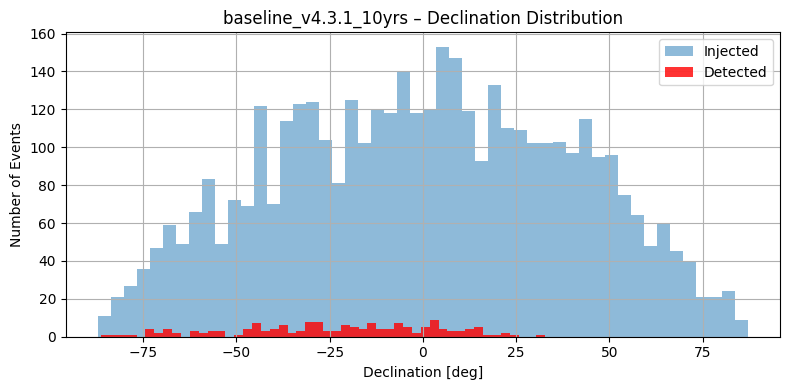

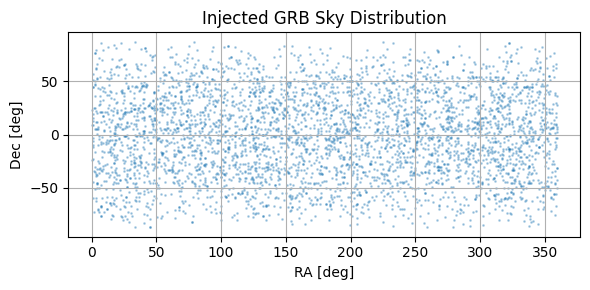

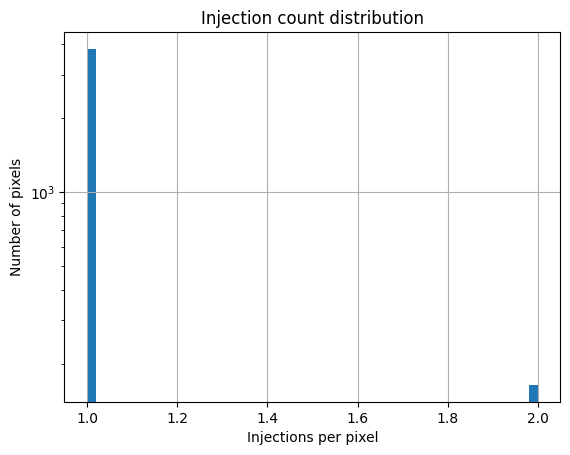

In [103]:
plt.figure(figsize=(8, 4))

plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
plt.xlabel("Declination [deg]")
plt.ylabel("Number of Events")
plt.title(f"{cadence} – Declination Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(np.degrees(ra_rad), np.degrees(dec_rad), s=1, alpha=0.3)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Injected GRB Sky Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.hist(injected_map[injected_map > 0], bins=50, log=True)
plt.xlabel("Injections per pixel")
plt.ylabel("Number of pixels")
plt.title("Injection count distribution")
plt.grid(True)
plt.show()



## Per year


=== Running GRB Detect-only for cadence: four_roll_v4.3.1_10yrs ===

--- Year 1: Days 1 to 365 ---
Year 1: 48 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


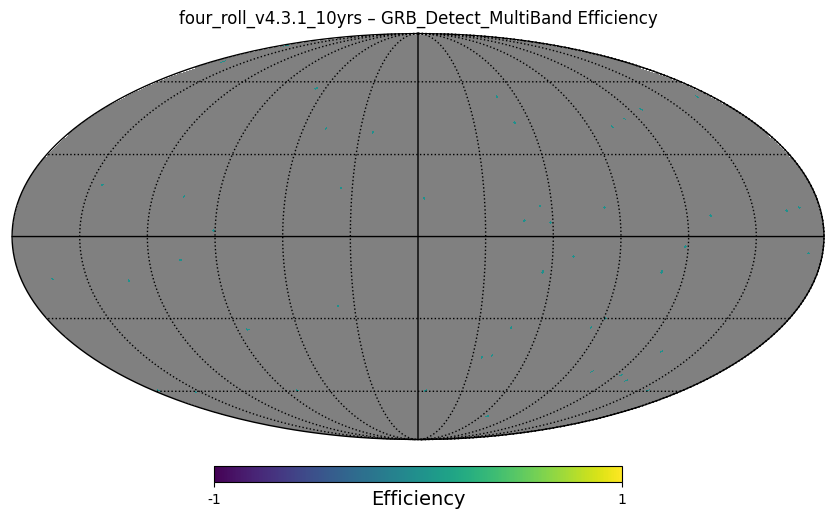

[SUMMARY] Year 1: 0 / 48 events detected.

--- Year 2: Days 365 to 730 ---
Year 2: 37 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


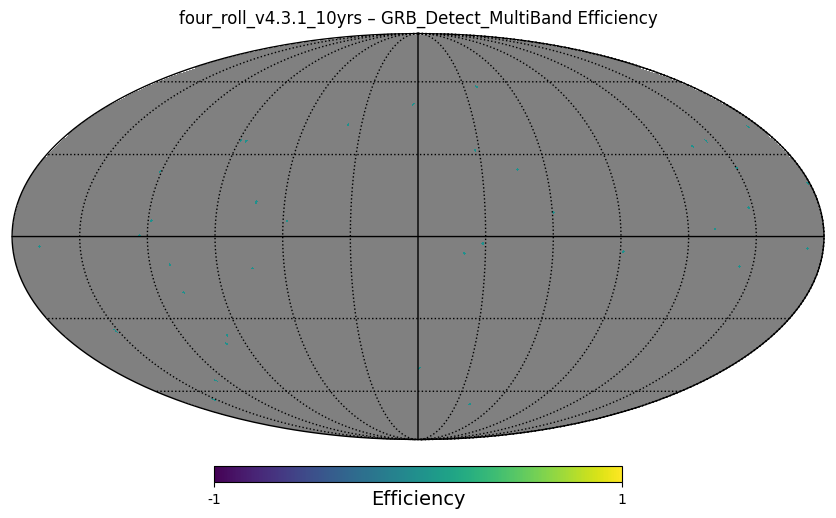

[SUMMARY] Year 2: 0 / 37 events detected.

--- Year 3: Days 730 to 1095 ---
Year 3: 42 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


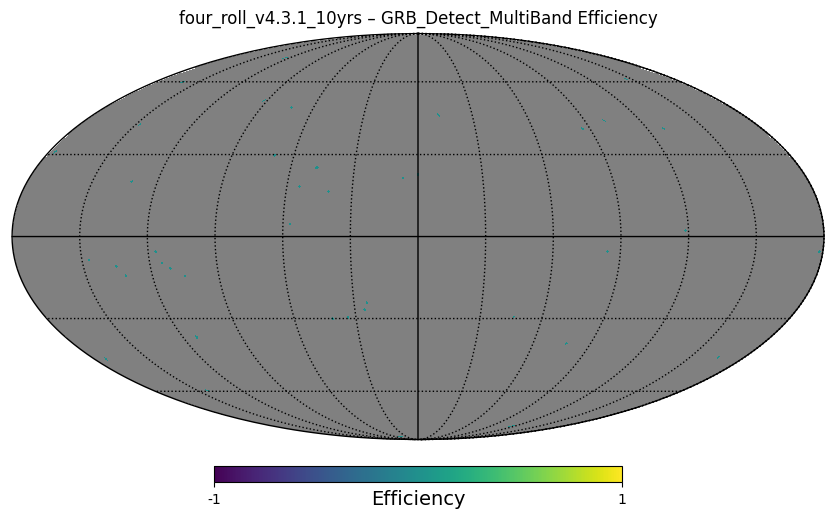

[SUMMARY] Year 3: 0 / 42 events detected.

--- Year 4: Days 1095 to 1460 ---
Year 4: 38 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


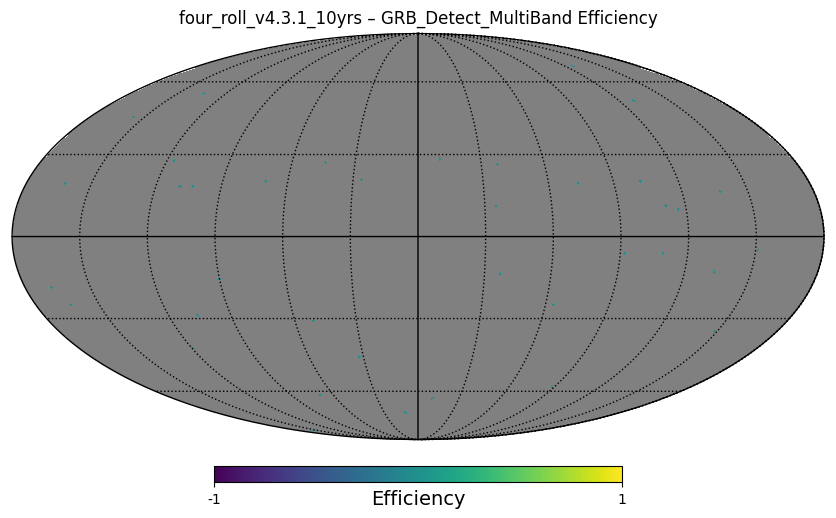

[SUMMARY] Year 4: 0 / 38 events detected.

--- Year 5: Days 1460 to 1825 ---
Year 5: 47 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


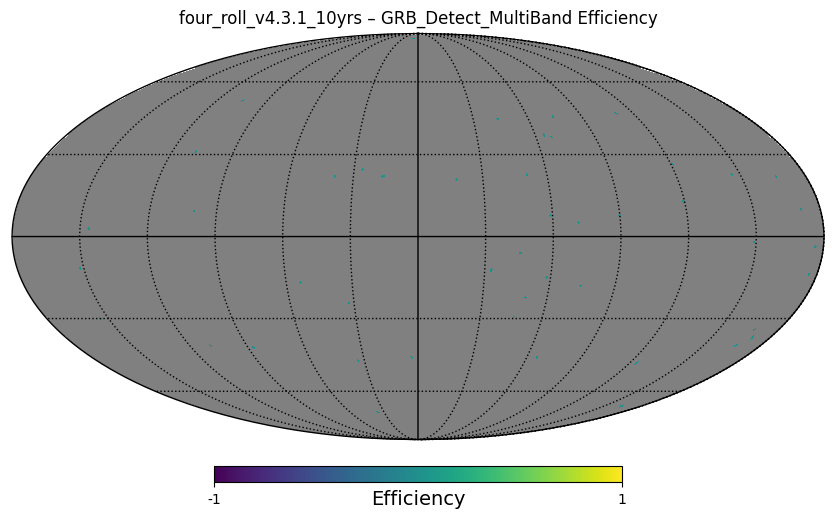

[SUMMARY] Year 5: 0 / 47 events detected.

--- Year 6: Days 1825 to 2190 ---
Year 6: 46 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


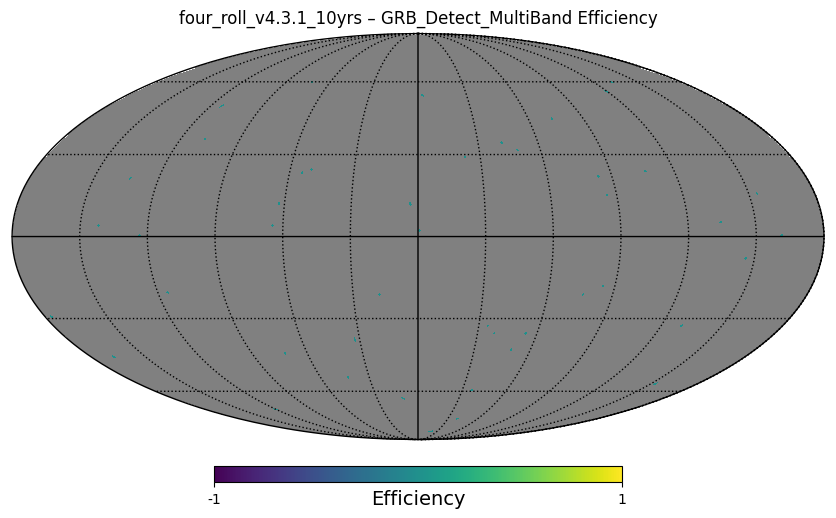

[SUMMARY] Year 6: 0 / 46 events detected.

--- Year 7: Days 2190 to 2555 ---
Year 7: 43 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


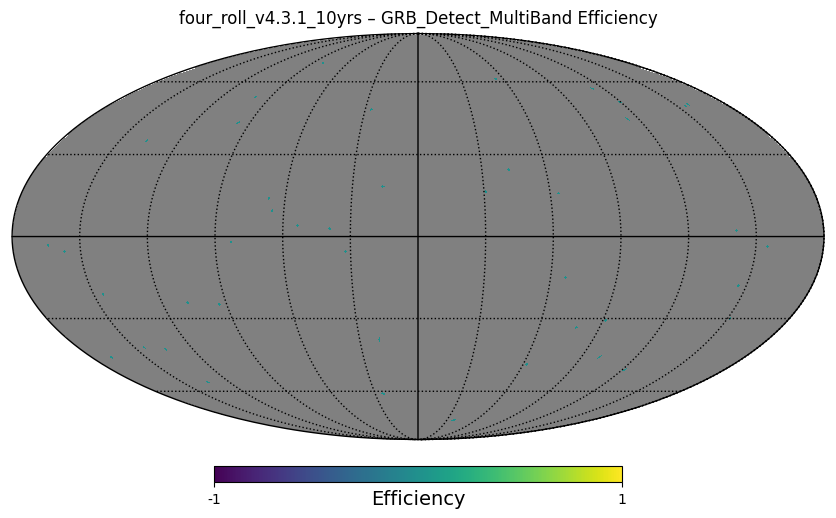

[SUMMARY] Year 7: 0 / 43 events detected.

--- Year 8: Days 2555 to 2920 ---
Year 8: 36 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


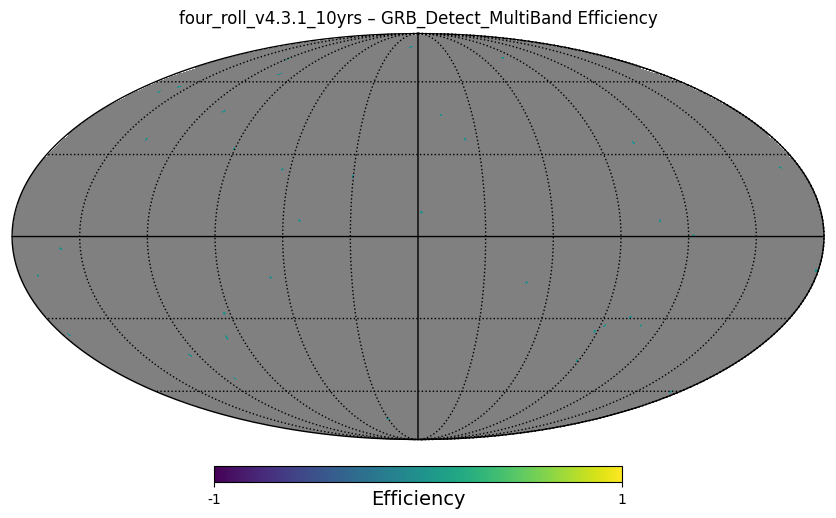

[SUMMARY] Year 8: 0 / 36 events detected.

--- Year 9: Days 2920 to 3285 ---
Year 9: 32 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


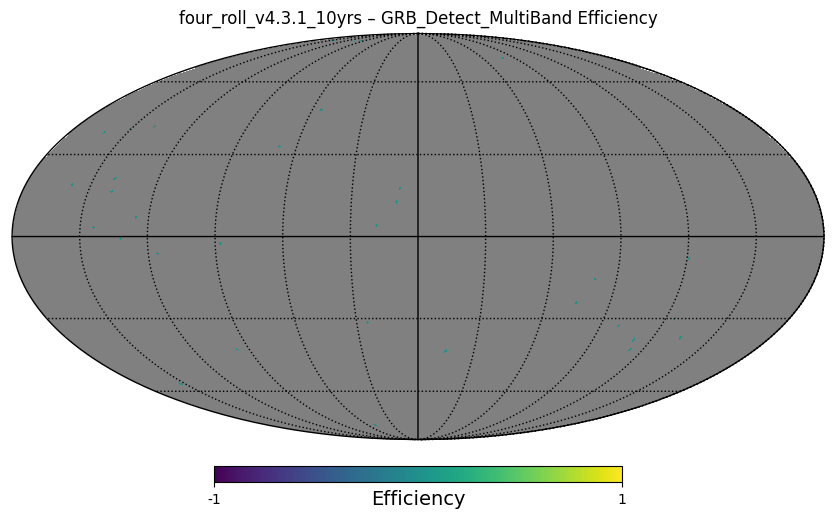

[SUMMARY] Year 9: 0 / 32 events detected.

--- Year 10: Days 3285 to 3652 ---
Year 10: 28 events passed time filter.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


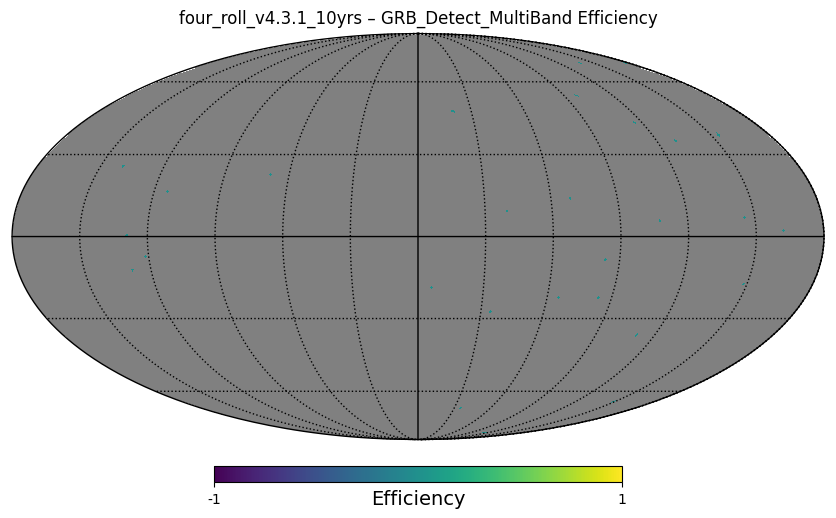

[SUMMARY] Year 10: 0 / 28 events detected.


ValueError: not enough values to unpack (expected 3, got 0)

In [122]:
# ---- Per Year Configuration ----
year_intervals = [
    (1, 365), (365, 730), (730, 1095), (1095, 1460), (1460, 1825),
    (1825, 2190), (2190, 2555), (2555, 2920), (2920, 3285), (3285, 3652)
]
first = 1

def filter_population_by_mjd(slicer, mjd_start, mjd_end, mjd0=59853.5):
    peak_times = slicer.slice_points['peak_time'] + mjd0
    mask = (peak_times >= mjd_start) & (peak_times < mjd_end)
    ra = slicer.slice_points['ra'][mask]
    dec = slicer.slice_points['dec'][mask]
    new_slicer = UserPointsSlicer(ra=ra, dec=dec, badval=0)
    new_slice_points = {k: v[mask] for k, v in slicer.slice_points.items()}

    # Resequence the SID to be 0 through len−1 for metric indexing
    new_slice_points['sid'] = np.arange(len(ra))
    new_slicer.slice_points = new_slice_points
    return new_slicer

yearly_detection_counts = []
for cadence in cadences:
    print(f"\n=== Running GRB Detect-only for cadence: {cadence} ===")
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"PY_Metric_temp_{cadence}")
    #opsdb = db_path

    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)
    
    for yr, (t0, t1) in enumerate(year_intervals):
        print(f"\n--- Year {yr+1}: Days {t0} to {t1} ---")

        # Filter the population to this year's time window
        #slicer_year = filter_population_by_time(slicer, t0, t1)
        # Convert night range to approximate MJD offset from mjd0
        mjd_start = t0 + 59853.5  # or your custom mjd0
        mjd_end   = t1 + 59853.5
        slicer_year = filter_population_by_mjd(slicer, mjd_start, mjd_end)
        print(f"Year {yr+1}: {len(slicer_year.slice_points['ra'])} events passed time filter.")


        
        # Add multi-band metrics
        multi_metrics = [
            GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
        ]



        for metric in multi_metrics:
            mb_key = f"{runName}_{metric.__class__.__name__}_Yr{yr+1}"
            bundle = metric_bundles.MetricBundle(
                metric, slicer_year, f'night >= {t0} and night < {t1}',
                file_root=mb_key, plot_funcs=[],
                summary_metrics=[metrics.SumMetric()]
            )
        
            bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
            bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
            bgroup.run_all()
            if first:
                df_yr = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
                df_yr["run"] = runName
                df_yr["year"] = yr
                first = 0
            else:
                _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
                _["run"] = runName  
                _["year"] = yr
                df_yr = pd.concat([df_yr, _])
            # Healpix plotting
    
            nside = slicer_year.nside if hasattr(slicer_year, 'nside') else 64
            npix = hp.nside2npix(nside)
            injected_map = np.zeros(npix)
            detected_map = np.zeros(npix)
            
            ra_rad = slicer_year.slice_points['ra']
            dec_rad = slicer_year.slice_points['dec']
            pix_inds = hp.ang2pix(nside, 0.5 * np.pi - dec_rad, ra_rad)
            
            for i, pix in enumerate(pix_inds):
                injected_map[pix] += 1
                if bundle.metric_values[i] == 1:
                    if np.random.rand() < 0.001:
                        print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                    detected_map[pix] += 1
            
                        

            eff_map = np.zeros(npix)
            mask = injected_map > 0
            eff_map[mask] = detected_map[mask] / injected_map[mask]
            eff_map[~mask] = hp.UNSEEN
            
            hp.mollview(eff_map, title=f"{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
            hp.graticule()
            #plt.tight_layout()
            plt.show()

            # Count detections per year
            metric_vals = bundle.metric_values
            n_total = len(metric_vals)
            n_detected = np.sum(metric_vals == 1)
            
            print(f"[SUMMARY] Year {yr+1}: {n_detected} / {n_total} events detected.")
            
            # Store results
            if 'yearly_detection_counts' not in locals():
                
                yearly_detection_counts.append((yr + 1, n_detected, n_total))

    years, detected_counts, total_counts = zip(*yearly_detection_counts)
    plt.figure(figsize=(8, 5))
    plt.bar(years, detected_counts, color='mediumblue', alpha=0.7, label='Detected')
    plt.plot(years, total_counts, 'ko--', label='Injected (per year)')
    plt.xlabel("Year")
    plt.ylabel("Number of GRBs Detected")
    plt.title("GRB Afterglow Detections Per Year")
    plt.xticks(ticks=years)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
df_yr

In [ ]:
# ---- Per Year Configuration ----
year_intervals = [
    (1, 365), (365, 730), (730, 1095), (1095, 1460), (1460, 1825),
    (1825, 2190), (2190, 2555), (2555, 2920), (2920, 3285), (3285, 3652)
]


os.makedirs(os.path.dirname(full_grb_pop_file), exist_ok=True)

# ---- Template Setup ----
if not os.path.exists(grb_templates_file):
    from local_GRBafterglows_metric import generateGRBAfterglowTemplates
    generateGRBAfterglowTemplates(save_to=grb_templates_file)
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

# ---- Population Setup ----
if not os.path.exists(grb_pop_file):
    slicer = generateGRBPopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut, rate_density=rate_density,
        save_to=grb_pop_file
    )
else:
    slicer = generateGRBPopSlicer(load_from=grb_pop_file)

n_events = len(slicer.slice_points['distance'])

full_slicer = generateGRBPopSlicer(load_from=full_grb_pop_file)

print(f"Injecting population using rate_density = {rate_density:.1e}")


# ---- Main Loop over Cadences and Years ----
for cadence in cadences:
    print(f"\n=== Running GRB Detect-only for cadence: {cadence} ===")
    runName = cadence
    db_path = os.path.join(db_dir, f"{cadence}.db")
    opsdb = db_path

    outDir = os.path.join(out_dir_base, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)
    
    for yr, (t0, t1) in enumerate(year_intervals):
        print(f"\n Year {yr+1}: {t0}-{t1} days")
        slicer = filter_population_by_time(full_slicer, t0, t1)
        print(f"Sample Decs for {cadence}, Year {yr+1}: {np.degrees(slicer.slice_points['dec'][:10])}")
        n_events = len(slicer.slice_points['distance'])
        print(f"Injected GRBs in year {yr+1}: {n_events}")

        
        peak_mags = []
        ras = []
        decs = []
        detected_flags = []
        
        for i in range(n_events):
            ra = slicer.slice_points['ra'][i]
            dec = slicer.slice_points['dec'][i]
            d = slicer.slice_points['distance'][i]
            ebv = slicer.slice_points['ebv'][i]
            file_indx = slicer.slice_points['file_indx'][i]
        
            m_peak = shared_lc_model.interp(0, filtername, lc_indx=file_indx)
            A = ax1[filtername] * ebv
            dm = 5 * np.log10(d * 1e6) - 5
            m_app = m_peak + dm + A
        
            peak_mags.append(m_app)
            ras.append(ra)
            decs.append(dec)
            detected_flags.append(False)  # We'll update this next
        
        # --- Update detection flags ---
        for f in filters:
            vals = per_filter_metrics[f"GRB_Detect_{f}"].metric_values
            mask = ~vals.mask if hasattr(vals, 'mask') else np.ones(len(vals), dtype=bool)
            for i in range(n_events):
                if (vals[i] == 1) and mask[i]:
                    detected_flags[i] = True
        
        # --- Plot RA ---
        plt.figure(figsize=(8, 4))
        plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
        plt.scatter(np.array(ras)[detected_flags], np.array(peak_mags)[detected_flags],
                    c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
        plt.xlabel('RA [deg]')
        plt.ylabel(f'Apparent Peak Magnitude ({filtername}-band)')
        plt.title(f'{cadence}, Year {yr+1} — Peak Apparent Mag vs RA')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        #plt.savefig(os.path.join(out_dir_base, f"{cadence}_{rate_str}_year{yr+1}_peakmag_vs_ra.png"))
        plt.show()
        
        # --- Plot Dec ---
        plt.figure(figsize=(8, 4))
        plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
        plt.scatter(np.array(decs)[detected_flags], np.array(peak_mags)[detected_flags],
                    c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
        plt.xlabel('Dec [deg]')
        plt.ylabel(f'Apparent Peak Magnitude ({filtername}-band)')
        plt.title(f'{cadence}, Year {yr+1} — Peak Apparent Mag vs Dec')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        #plt.savefig(os.path.join(out_dir_base, f"{cadence}_{rate_str}_year{yr+1}_peakmag_vs_dec.png"))
        plt.show()


        # -- Filter-level detection count per event --
        n_filters_detected_per_event = np.array([
            sum(
                per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
                and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
                for f in filters
            )
            for i in range(n_events)
        ])
        
        # -- Which events were detected in ≥1 filter --
        detected_mask = n_filters_detected_per_event >= 1
        
        n_detected = np.sum(detected_mask)
        if n_detected > 0:
            mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
            std_filters = np.std(n_filters_detected_per_event[detected_mask])
        else:
            mean_filters = 0.0
            std_filters = 0.0
        
        print(f"\n Out of {n_events} simulated GRB events, Rubin detected {n_detected} under the {cadence} cadence.")
        print(f"   Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


        print(f"\n Filter-wise detections for {cadence}, Year {yr+1}:")
        for f in filters:
            vals = per_filter_metrics[f"GRB_Detect_{f}"].metric_values
            mask = ~vals.mask if hasattr(vals, 'mask') else np.ones(len(vals), dtype=bool)
            found = np.sum((vals == 1) & mask)
            print(f"  {f}-band: {found} detections")


        # ---- Save Detection Summary CSV ----
        combined_csv = os.path.join(out_dir_base, f"{cadence}_{rate_str}_combined_detection_summary.csv")
        write_header = not os.path.exists(combined_csv)
        with open(combined_csv, "a") as out:
            if write_header:
                out.write("t_start,t_end,sid,ra,dec,peak_time,distance_Mpc,ebv,n_filters_detected,detected\n")
            for i in range(n_events):
                n_filters_detected = sum(
                    int((not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]) and
                        (per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1))
                    for f in filters
                )
                detected = int(n_filters_detected >= 1)
                out.write(f"{t0},{t1},{i},{slicer.slice_points['ra'][i]:.5f},{slicer.slice_points['dec'][i]:.5f},"
                          f"{slicer.slice_points['peak_time'][i]:.2f},{slicer.slice_points['distance'][i]:.2f},"
                          f"{slicer.slice_points['ebv'][i]:.3f},{n_filters_detected},{detected}\n")

        print(f"Saved detection summary to {combined_csv}")

        # ---- Mollview Plot (All Filter Detections) ----
        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = np.radians(slicer.slice_points['ra'])
        dec_rad = slicer.slice_points['dec']
        print("Dec (rad) before mollview theta conversion:", dec_rad[:10])
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)
        print("Theta range (mollview):", theta.min(), theta.max())
        print("Any bad theta?", np.any(np.isnan(theta)) or np.any(theta < 0) or np.any(theta > np.pi))

        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if any(per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
                   and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
                   for f in filters):
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(
            eff_map,
            title=f"{cadence} – Year {yr+1}: {t0}-{t1} days",
            unit='Efficiency',
            cmap='viridis'
        )
        print("Sample Decs (deg) for plotted map:", np.degrees(slicer.slice_points['dec'][:10]))

        hp.graticule()
        png_path = os.path.join(out_dir_base, f"{cadence}_{rate_str}_mollview_year{yr+1}.png")
        #plt.savefig(png_path, dpi=150)
        plt.show()  
        plt.close()
        print(f"Saved mollview to {png_path}")
